# Distributions

Suppose we are trying to emulate a simulator's outputs $f(x) \in \mathbb{R}^d$. If we consider a batch of $n$ outputs then then we'd want to retrieve output means $\mu \in \mathbb{R}^{nd}$ and covariances $\Sigma \in \mathbb{R}^{nd \times nd}$.
$$
\Sigma =
\begin{bmatrix}
\Sigma_{11} & \Sigma_{12} & \cdots & \Sigma_{1n} \\[6pt]
\Sigma_{21} & \Sigma_{22} & \cdots & \Sigma_{2n} \\[6pt]
\vdots      & \vdots      & \ddots & \vdots      \\[6pt]
\Sigma_{n1} & \Sigma_{n2} & \cdots & \Sigma_{nn}
\end{bmatrix} \in \mathbb{R}^{nd \times nd}
\quad \text{s.t.} \quad 
\Sigma_{ij} \in \mathbb{R}^{d \times d}
$$
where $\Sigma_{ii}$ is the *marginal covariance* and $\Sigma_{ij}$ is the *cross-covariance*.

There are a couple of scenarios we want to consider:
1. **Full**: no simplification to the above covariance matrix.
2. **Block-diagonal**: $\Sigma_{ij} = 0$ for all $i\neq j$, i.e. no correlations between samples.
3. **Diagonal**: $\Sigma_{ij} = 0$ for all $i\neq j$ and $\Sigma_{ii}^{(a, b)} = 0$ for all $a \neq b$, i.e. no correlations between sample dimensions.
4. **Seperable**: $\Sigma = \Sigma_{N} \otimes \Sigma_{D}$ s.t. $\Sigma_{\text{N}} \in \mathbb{R}^{n \times n}$ and $\Sigma_{\text{D}} \in \mathbb{R}^{d \times d}$, i.e. correlations between samples and dimensions are modelled seperately. 

Note that:
$$
\begin{aligned}
\text{Full} &\supseteq \text{Block-Diagonal} \supseteq \text{Diagonal} \\
\text{Full} &\supseteq \text{Seperable}
\end{aligned}
$$

In [83]:
import torch, time, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from autoemulate.experimental.data.gaussian import *
from dataclasses import dataclass
from typing import List, Dict
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Remember that our simulation can be viewed as a function
$$
f: \mathcal{X} \to \mathcal{Y}.
$$
Suppose that the output space if `d`-dimensional, i.e. $\mathcal{Y} \subseteq \mathbb{R}^d$, and suppose we choose `n` sampling locations in the input space $\mathcal{X}$. Suppose that, for each each sampling location, we sample `k` times. Then we'd get a tensor of shape `(k, n, d)`. Let's start with that.

In [84]:
k, n, d = 1000, 50, 3
samples = torch.rand(k, n, d)

## Structured covariances

By using structured covariances we can use theoretical properties to speed up the computation of things such as the log determinant, trace, and maximum eigenvalue of the covariance matrix.

In [ ]:
def compare(classes: List[Structured], n_runs: int, n_list: List[int], d_list: List[int], k: int) -> pd.DataFrame:

    # For timing and comparison
    def compare(f_struct, f_dense):
        t0 = time.perf_counter()
        r0 = float(f_struct())
        t1 = time.perf_counter()
        r1 = float(f_dense())
        t2 = time.perf_counter()
        T_struct, T_dense = t1 - t0, t2 - t1
        return T_struct, T_dense, r0, r1
    
    # Results
    results = []
    for cls in classes:
        for n in n_list:
            for d in d_list:
                for _ in range(n_runs):
                    # Generate random samples
                    samples = torch.rand(k, n, d)
                    dist_struct = cls.from_dense(Empirical(samples))
                    dist_dense = dist_struct.to_dense()
                    for f_struct, f_dense in zip(
                        [dist_struct.logdet, dist_struct.trace, dist_struct.max_eig],
                        [dist_dense.logdet, dist_dense.trace, dist_dense.max_eig]
                    ):
                        T_struct, T_dense, r0, r1 = compare(f_struct, f_dense)
                        results.append({
                            "Type": cls.__name__,
                            "Function": f_struct.__name__,
                            "Dense time": T_dense,
                            "Structured time": T_struct,
                            "Dense result": r0,
                            "Structured result": r1,
                            "Size": n * d
                        })
    return pd.DataFrame(results)

In [87]:
def plot_results(results: pd.DataFrame, type: str, function: str, metric: str, ax=None):
    sub = results[(results["Type"] == type) & (results["Function"] == function)]
    sub = sub.groupby("Size")[metric].agg(mean="mean", std="std").reset_index()
    if ax is None:
        fig, ax = plt.subplots()
    plt.plot(
        sub["Size"], sub["mean"], label=f"{type} {function} {metric}", marker="o", linestyle="-"
    )
    plt.fill_between(
        sub["Size"],
        sub["mean"] - sub["std"],
        sub["mean"] + sub["std"],
        alpha=0.2,
    )

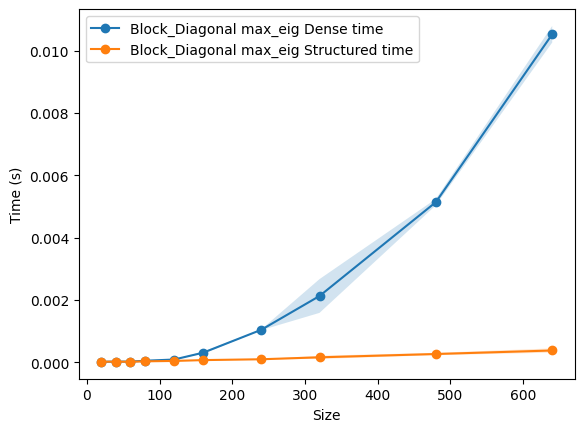

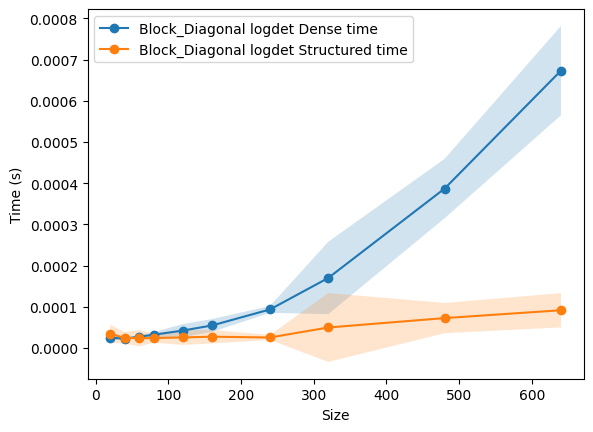

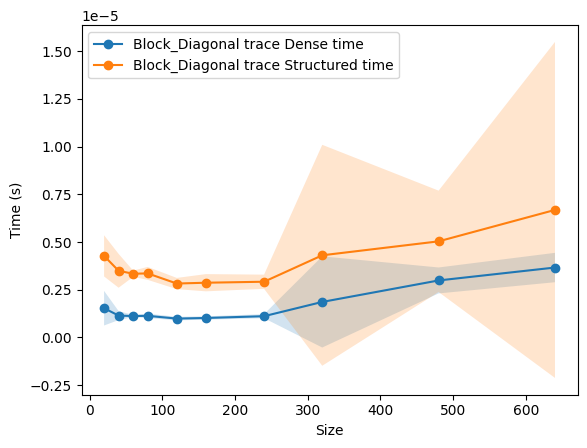

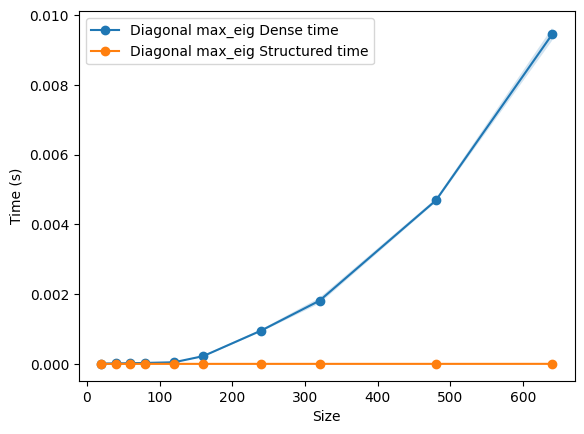

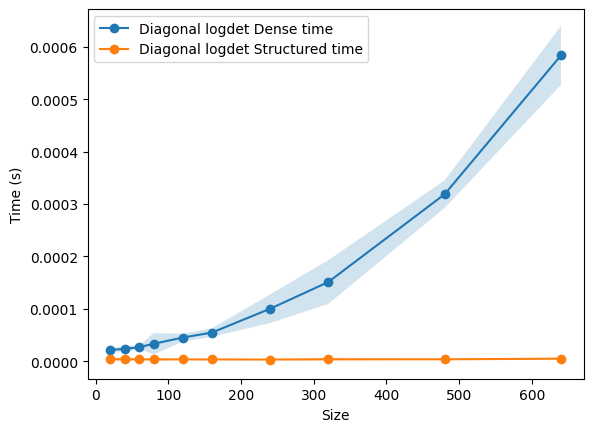

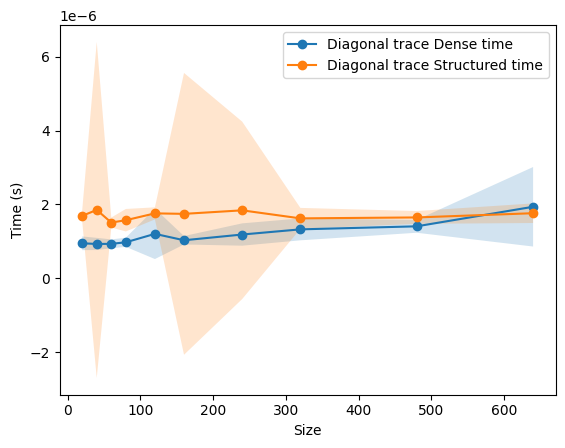

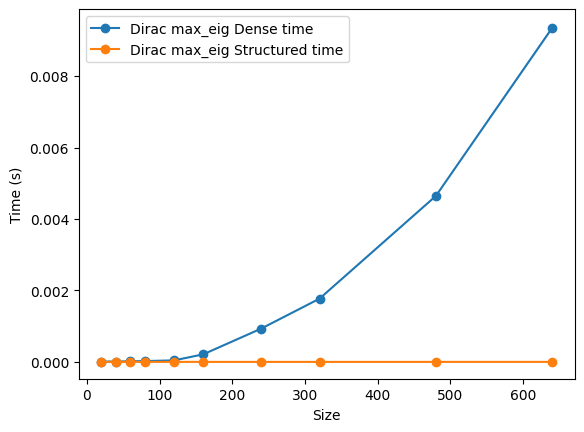

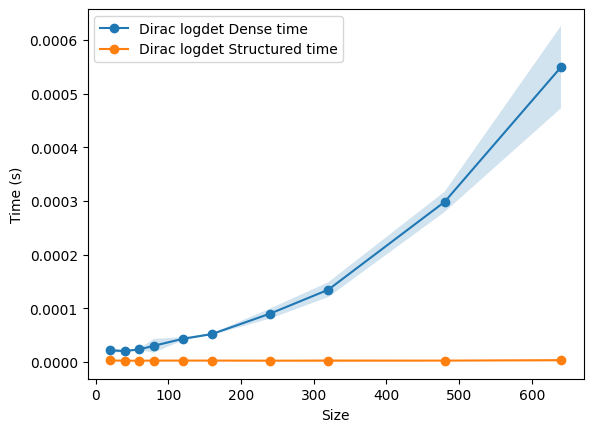

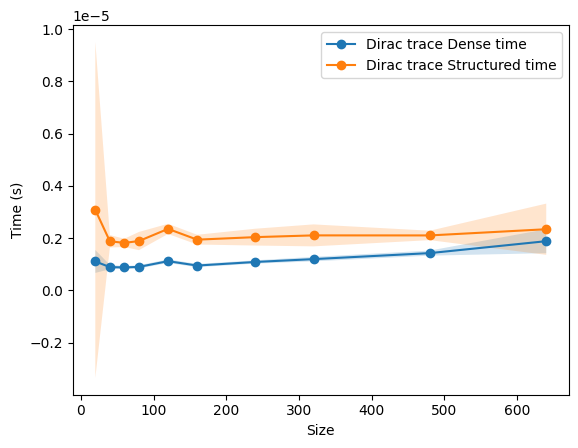

In [111]:
results = compare([Block_Diagonal, Diagonal, Dirac], 100, [10, 20, 30, 40], [2, 4, 8, 16], 100)

fig, ax = plt.subplots()
plot_results(results, "Block_Diagonal", "max_eig", "Dense time", ax=ax)
plot_results(results, "Block_Diagonal", "max_eig", "Structured time", ax=ax)
plt.xlabel("Size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()
fig, ax = plt.subplots()
plot_results(results, "Block_Diagonal", "logdet", "Dense time", ax=ax)
plot_results(results, "Block_Diagonal", "logdet", "Structured time", ax=ax)
plt.xlabel("Size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()
fig, ax = plt.subplots()
plot_results(results, "Block_Diagonal", "trace", "Dense time", ax=ax)
plot_results(results, "Block_Diagonal", "trace", "Structured time", ax=ax)
plt.xlabel("Size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

fig, ax = plt.subplots()
plot_results(results, "Diagonal", "max_eig", "Dense time", ax=ax)
plot_results(results, "Diagonal", "max_eig", "Structured time", ax=ax)
plt.xlabel("Size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()
fig, ax = plt.subplots()
plot_results(results, "Diagonal", "logdet", "Dense time", ax=ax)
plot_results(results, "Diagonal", "logdet", "Structured time", ax=ax)
plt.xlabel("Size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()
fig, ax = plt.subplots()
plot_results(results, "Diagonal", "trace", "Dense time", ax=ax)
plot_results(results, "Diagonal", "trace", "Structured time", ax=ax)
plt.xlabel("Size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

fig, ax = plt.subplots()
plot_results(results, "Dirac", "max_eig", "Dense time", ax=ax)
plot_results(results, "Dirac", "max_eig", "Structured time", ax=ax)
plt.xlabel("Size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()
fig, ax = plt.subplots()
plot_results(results, "Dirac", "logdet", "Dense time", ax=ax)
plot_results(results, "Dirac", "logdet", "Structured time", ax=ax)
plt.xlabel("Size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()
fig, ax = plt.subplots()
plot_results(results, "Dirac", "trace", "Dense time", ax=ax)
plot_results(results, "Dirac", "trace", "Structured time", ax=ax)
plt.xlabel("Size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()


## Ensemble of Gaussians

Let $K \in \mathbb{N}$ be the number of Gaussians. Then the mean and covariance of an ensemble of Gaussians is given by

$$
\mu
= \frac{1}{K}
  \sum_{i=1}^{K}
    \mu_i,
$$
$$
\Sigma
= \frac{1}{K}
  \sum_{i=1}^{K}
    \Sigma_i
+
  \frac{1}{K - 1}
  \sum_{i=1}^{K}
    \bigl(\mu_i - \mu\bigr)
    \bigl(\mu_i - \mu\bigr)^\top.
$$

In [47]:
dist_ens = Ensemble([
    dist_dense, dist_bd, dist_diag, dist_dirac, dist_sep
])
dist_ens.logdet(), dist_ens.trace(), dist_ens.max_eig()

(tensor(-29.7939), tensor(0.4056), tensor(0.1747))